In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from typing import List
from matplotlib.animation import FuncAnimation
import torch.nn.functional as F
from typing import Tuple
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from typing import Optional
from tqdm.notebook import tqdm, trange

%matplotlib widget
np.set_printoptions(precision=2, suppress=True, linewidth=200, threshold=200)

In [188]:
grid_size = 10

observation_dim = 1
action_dim = 1
reward_dim = 1
value_dim = 1
transition_dim = observation_dim + action_dim + reward_dim + value_dim
n_transitions = grid_size
seq_len = n_transitions * transition_dim
vocab_size = grid_size * grid_size # choose 100 because we have 100 unique states
max_bins = 100
discount_factor = 0.99
embedding_dim = 32

n_heads = 4
n_blocks = 4
n_epochs = 5
batch_size = 256
lr = 0.0006
eval_every = 1

beam_width = 32 # number of top-k sequences to keep in beam search
beam_steps = 10 # number of steps to run beam search
beam_context = 5 # number of steps to consider in beam search
plan_every = 1
sample_expansion = 2 # number of samples to generate at each step of beam search, choose 2 because we have 4 actions
obs_top_k = 1 # top-k to consider for logits of observation
act_top_k = 2 # top-k to consider for logits of action
rew_top_k = None # top-k to consider for logits of reward/value

num_episodes = 100

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [189]:

class GridMazeEnv(gym.Env):
    def __init__(self, grid_size: int=5, goal_position: tuple = (4, 4), obstacles: List[tuple]=None):
        super().__init__()
        self.grid_size = grid_size
        self.goal_position = goal_position
        self.obstacles = obstacles
        self.action_space = spaces.Discrete(4)  # Up, Down, Left, Right
        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size)
        self.reset()
        self.moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    def _get_state(self):
        return self.agent_position[0] * self.grid_size + self.agent_position[1]

    def reset(self):
        self.agent_position = [0, 0]
        self.state = self._get_state()
        return self.state

    def step(self, action: int):
        # Define movements: 0=Up, 1=Down, 2=Left, 3=Right
        moves = self.moves
        next_position = [
            self.agent_position[0] + moves[action][0],
            self.agent_position[1] + moves[action][1],
        ]

        # Check for boundary conditions
        if 0 <= next_position[0] < self.grid_size and 0 <= next_position[1] < self.grid_size:
            if tuple(next_position) not in self.obstacles:
                self.agent_position = next_position

        reward = -0.01  # Small penalty for each move
        done = False

        if tuple(self.agent_position) == self.goal_position:
            reward = 1.0
            done = True

        self.state = self._get_state()

        return self.state, reward, done, {}

    def render(self):
        pass


    def close(self):
        pass


In [190]:
from queue import PriorityQueue


def huristic_policy(env: GridMazeEnv):
    # Define movements: 0=Up, 1=Down, 2=Left, 3=Right
    moves = env.moves
    state = env.agent_position
    goal_position = env.goal_position
    # Calculate distance to goal
    distances = [
        abs(goal_position[0] - (state[0] + moves[i][0])) + abs(goal_position[1] - (state[1] + moves[i][1]))
        for i in range(4)
    ]
    # Choose action with minimum distance
    action = np.argmin(distances)
    return action


def shortest_path(env: GridMazeEnv):

    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def get_neighbors(position):
        neighbors = []
        for move in env.moves:
            next_position = (position[0] + move[0], position[1] + move[1])
            if 0 <= next_position[0] < env.grid_size and 0 <= next_position[1] < env.grid_size:
                if next_position not in env.obstacles:
                    neighbors.append(next_position)
        return neighbors

    start = tuple(env.agent_position)
    goal = env.goal_position

    frontier = PriorityQueue()
    frontier.put((0, start))
    came_from = {start: None}
    cost_so_far = {start: 0}

    while not frontier.empty():
        _, current = frontier.get()

        if current == goal:
            break

        for next in get_neighbors(current):
            new_cost = cost_so_far[current] + 1
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next)
                frontier.put((priority, next))
                came_from[next] = current

    # Reconstruct path
    current = goal
    path = []
    while current != start:
        path.append(current)
        current = came_from[current]
    path.reverse()

    # Determine the first move
    first_move = path[0]
    action = env.moves.index((first_move[0] - start[0], first_move[1] - start[1]))
    return action


def random_policy(env: GridMazeEnv):
    return env.action_space.sample()


def collect_trajectories(env: GridMazeEnv, num_episodes: int = 100, policy: Optional[str] = None):
    trajectories = []
    explore_rate = 0.5
    for _ in range(num_episodes):
        state = env.reset()
        trajectory = []
        done = False
        while not done:
            if policy is None:
                policy = np.random.choice(['heuristic', 'shortest_path', 'random'], p=[0.6, 0.0, 0.4])
            if policy == 'heuristic':
                action = random_policy(env) if random.random() < explore_rate else huristic_policy(env)
            elif policy == 'shortest_path':
                action = shortest_path(env) # 
            elif policy == 'random':
                action = random_policy(env)
            else:
                raise ValueError('Invalid policy')
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, next_state, action, reward, done))
            state = next_state
            env.render()
        trajectories.append(trajectory)
    env.close()
    return trajectories


In [191]:
# Initialize environment and model

def generate_obstacles(grid_size: int, num_obstacles: int):
    obstacles = []
    for _ in range(num_obstacles):
        obstacle = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
        if obstacle != (0, 0) and obstacle != (grid_size - 1, grid_size - 1):
            obstacles.append(obstacle)
    return obstacles

env = GridMazeEnv(
    obstacles=generate_obstacles(grid_size, num_obstacles=grid_size),
    grid_size=grid_size,
    goal_position=(grid_size-1, grid_size-1)
)

# Collect trajectories
trajectories = collect_trajectories(env, num_episodes=num_episodes)
print(f"Number of trajectories: {len(trajectories)}")


Number of trajectories: 100


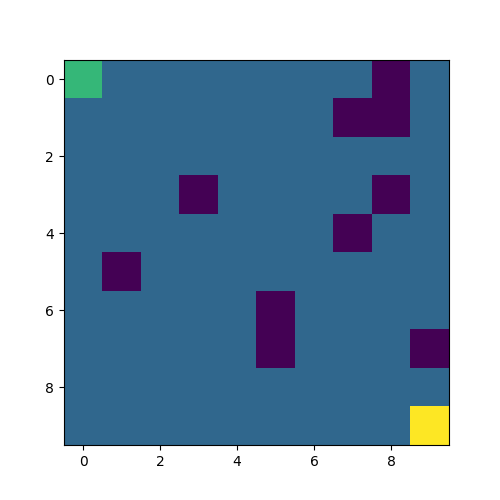

In [192]:
def animate_trajectory(env, trajectory):
    """
    Animates a trajectory in the GridMazeEnv environment.

    Args:
        env (GridMazeEnv): The environment instance.
        trajectory (List[Tuple[np.ndarray, int, float]]): The trajectory containing states, actions, and rewards.

    Returns:
        FuncAnimation: The animation object.
    """

    def _get_grid(state: int) -> np.ndarray:
        """
        Converts a state integer to a 2D grid.
        """
        grid = np.zeros((env.grid_size, env.grid_size))
        grid[state // env.grid_size, state % env.grid_size] = 1
        grid[env.goal_position[0], env.goal_position[1]] = 2
        for obstacle in env.obstacles:
            grid[obstacle[0], obstacle[1]] = -1
        return grid
    # Initialize the figure and axis
    fig, ax = plt.subplots(figsize=(5, 5))

    # Reset the environment and render the initial state
    initial_state = env.reset()
    grid = _get_grid(initial_state)
    im = ax.imshow(grid, cmap="viridis", origin="upper")

    def update(frame):
        """
        Update function for each animation frame.
        """
        state, next_state, action, reward, done = trajectory[frame]

        grid = _get_grid(state)
        next_grid = _get_grid(next_state)
        # Ensure the state is a 2D array
        if isinstance(grid, np.ndarray) and grid.ndim == 2:
            combined_state = grid.copy()
            combined_state[next_grid == 1] = 1
            combined_state[grid == 1] = 0.5
            im.set_array(combined_state)
            ax.set_title(f"Step: {frame + 1}, Reward: {reward:.2f}, Action: {action}, Done: {done}")
        else:
            raise ValueError("State must be a 2D numpy array.")
        return [im]

    # Create the animation
    anim = FuncAnimation(
        fig, update, frames=len(trajectory), blit=False, repeat=True, interval=300
    )
    return anim


anim = animate_trajectory(env, trajectories[0])
plt.show()

In [193]:
# average length of trajectories
lengths = [len(traj) for traj in trajectories]
print(f"Average length of trajectories: {np.mean(lengths):.2f}, std: {np.std(lengths):.2f}")

Average length of trajectories: 39.12, std: 11.38


In [194]:
class KBinsDiscretizer:
    def __init__(self, dataset: np.ndarray, n_bins: int, strategy: str = "ordinal"):
        self.n_bins = n_bins
        self.strategy = strategy

        # bin_edges shape: (n_features, n_bins + 1)
        self.bin_edges = self._find_bin_edges(dataset)

        self.bin_centers = (self.bin_edges[:, :-1] + self.bin_edges[:, 1:]) * 0.5
        self.bin_centers_torch = torch.from_numpy(self.bin_centers).float()
    
    def _find_bin_edges(self, dataset: np.ndarray):
        bin_edges = []
        if self.strategy == "uniform":
            mins, maxs = np.min(dataset, axis=0), np.max(dataset, axis=0)
            bin_edges = np.linspace(mins, maxs, self.n_bins + 1).T
        elif self.strategy == "quantile":
            quantiles = np.linspace(0, 100, self.n_bins + 1)
            bin_edges = np.percentile(dataset, quantiles, axis=0).T
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
        return bin_edges
    
    def encode(self, X: np.ndarray, subslice: Optional[Tuple[int, int]] = None) -> np.ndarray:
        if X.ndim == 1:
            # this is to handle the case where we have a single sample
            X = X[None]
        # data shape: (n_samples, n_features)
        edges = self.bin_edges
        if subslice is not None:
            start, end = subslice
            edges = edges[start:end]
        
        Xt = np.zeros(X.shape, dtype=np.long)

        # See documentation of numpy.isclose for an explanation of ``rtol`` and ``atol``.
        rtol = 1.0e-5
        atol = 1.0e-8

        for jj in range(X.shape[1]):
            # Values which are close to a bin edge are susceptible to numeric
            # instability. Add eps to X so these values are binned correctly
            # with respect to their decimal truncation.
            eps = atol + rtol * np.abs(X[:, jj])
             # why [1:]? bins = edges - 1, but its unclear why we leave out the first element and not the last
            Xt[:, jj] = np.digitize(X[:, jj] + eps, edges[jj][1:])
        
        np.clip(Xt, 0, self.n_bins - 1, out=Xt)
        
        return Xt
    
    def decode(self, Xt: np.ndarray, subslice: Optional[Tuple[int, int]] = None) -> np.ndarray:
        if Xt.ndim == 1:
            # this is to handle the case where we have a single sample
            Xt = Xt[None]
        # data shape: (n_samples, n_features)
        centers = self.bin_centers
        if subslice is not None:
            start, end = subslice
            centers = centers[start:end]
        
        X = np.zeros(Xt.shape, dtype=np.float64)
        for jj in range(Xt.shape[1]):
            X[:, jj] = centers[jj, np.int_(Xt[:, jj])]
        
        return X
    
    def expectation(self, probs: np.ndarray, subslice: Optional[Tuple[int, int]] = None) -> np.ndarray:
        if probs.ndim == 1:
            # this is to handle the case where we have a single sample
            probs = probs[None]
        # probs shape: (batch_size, n_features, n_bins)
        # bin_centers shape: (n_features, n_bins) -> (1, n_features, n_bins)
        if torch.is_tensor(probs):
            bin_centers = self.bin_centers_torch.unsqueeze(0)
        else:
            # bin_centers shape: (n_features, n_bins) -> (1, n_features, n_bins)
            bin_centers = self.bin_centers[None]
        
        if subslice is not None:
            start, end = subslice
            bin_centers = bin_centers[:, start:end]
        
        # (batch_size, n_features, n_bins) * (1, n_features, n_bins) -> sum (batch_size, n_features, n_bins) -> (batch_size, n_features)
        X = (probs * bin_centers).sum(axis=-1)
        return X
    
    def to(self, device):
        self.bin_centers_torch = self.bin_centers_torch.to(device)
        

In [195]:
# Test array
test_arr = np.array([[1, 2], [3, 4], [5, 6]])

# Initialize the discretizer
discretizer = KBinsDiscretizer(test_arr, 1000, strategy="uniform")

# Encode and decode the test array
encoded = discretizer.encode(test_arr)
decoded = discretizer.decode(encoded)

# Check if the decoded array is close to the original array
assert np.isclose(decoded, test_arr, atol=1e-2).all(), f"Decoded array {decoded} is not close to the original array {test_arr}"

# Generate random probabilities
probs = F.softmax(torch.from_numpy(np.random.rand(3, 2, 1000)), dim=-1).numpy()

# Calculate the expectation
expectation = discretizer.expectation(probs)

# Check if the expectation is close to the mean of the test array
expected_mean = np.tile(np.mean(test_arr, axis=0), (3, 1))
assert np.isclose(expectation, expected_mean, atol=1e-1).all(), f"Expectation {expectation} is not close to the expected mean {expected_mean}"

print("All tests passed successfully.")

All tests passed successfully.


In [196]:
def join_trajectory(states: List[np.ndarray], actions: List[int], rewards: List[float], discount: float = 0.99):
    trajectory_len = len(states)

    values = np.zeros(trajectory_len)
    # calculate rewards to go with discount
    for i in range(trajectory_len - 1, -1, -1):
        values[i] = rewards[i] + (discount * values[i + 1] if i + 1 < trajectory_len else 0)
    
    # flatten the states (trajectory_len, grid_size, grid_size) -> (trajectory_len, grid_size*grid_size)
    states = np.array(states).reshape(trajectory_len, -1)
    actions = np.array(actions).reshape(trajectory_len, -1)
    rewards = np.array(rewards).reshape(trajectory_len, -1)
    values = values.reshape(trajectory_len, -1)

    joined = np.concatenate([states, actions, rewards, values], axis=-1)

    return joined


class DiscretizeDataset(Dataset):
    # Each input into the sequence model needs to be (batch_size, tokens)
    # output should be in groups of transitions
    def __init__(self, trajectories: List[List[tuple]], n_transitions: int, discount: float = 0.99, max_bins: int = 1000):
        self.trajectories = trajectories
        self.n_transitions = n_transitions

        trajectory_lengths = [len(trajectory) for trajectory in trajectories]

        self.joined_trajectories = []
        for i in range(len(trajectories)):
            states, _, actions, rewards, _ = zip(*trajectories[i])
            self.joined_trajectories.append(join_trajectory(states, actions, rewards, discount))
        
        self.discretizer = KBinsDiscretizer(
            n_bins=max_bins,
            strategy='quantile',
            dataset=np.concatenate(self.joined_trajectories, axis=0)
        )
        
        indices = []
        for traj_idx, traj_len in enumerate(trajectory_lengths):
            end = traj_len - 1
            for i in range(end):
                indices.append((traj_idx, i, i + n_transitions))
        
        self.indices = np.array(indices)
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        traj_idx, start, end = self.indices[idx]
        # shape (start - end)
        joined = self.joined_trajectories[traj_idx][start:end]
        loss_pad_mask = np.ones((self.n_transitions, joined.shape[-1]), dtype=np.float32)
        if joined.shape[0] < self.n_transitions:
            joined = np.pad(joined, ((0, self.n_transitions - joined.shape[0]), (0, 0)), mode='constant', constant_values=0)
            loss_pad_mask[joined.shape[0]:] = 0
        
        joined_discretized = self.discretizer.encode(joined)
        joined_discretized = joined_discretized.reshape(-1).astype(np.long)
        loss_pad_mask = loss_pad_mask.reshape(-1)
        return joined_discretized[:-1], joined_discretized[1:], loss_pad_mask[:-1]

dataset = DiscretizeDataset(trajectories, n_transitions, discount=discount_factor, max_bins=max_bins)

print(f"Length of dataset: {len(dataset)}")
print(f"Shape of dataset: {dataset[0][0].shape}, {dataset[0][1].shape}")

Length of dataset: 3812
Shape of dataset: (39,), (39,)


In [197]:
class Block(nn.Module):
    def __init__(self, seq_len, embedding_dim: int, n_heads: int):
        super().__init__()
        self.attn = nn.MultiheadAttention(embedding_dim, n_heads, batch_first=True)
        self.attn_norm = nn.LayerNorm(embedding_dim)

        self.fc1 = nn.Linear(embedding_dim, embedding_dim * 2)
        self.fc2 = nn.Linear(embedding_dim * 2, embedding_dim)
        self.fc_norm = nn.LayerNorm(embedding_dim)

        # mask value of true means that the value is not allowed to be attended to
        self.register_buffer('mask', ~torch.tril(torch.ones(seq_len, seq_len)).bool())
        # transition_dim - 1 stores rewards to go, we don't want to attend to them because they contain future information
        self.mask[:, transition_dim - 1::transition_dim] = True
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape (batch_size, n_tokens, embedding_dim)
        _, n_tokens, _ = x.shape
        # attn_mask shape (seq_len, seq_len), but incoming shape is (batch_size, n_tokens, embedding_dim)
        # so filter the mask to the correct size (n_tokens, n_tokens)
        attn_mask = self.mask[:n_tokens, :n_tokens]
        # attn_output shape (batch_size, n_tokens, embedding_dim)
        attn_output, _ = self.attn(x, x, x, attn_mask=attn_mask)
        # add and norm
        # attn_output shape (batch_size, n_tokens, embedding_dim)
        attn_output = self.attn_norm(attn_output + x)

        # fc_output shape (batch_size, n_tokens, embedding_dim)
        fc_output = self.fc1(attn_output)
        fc_output = torch.relu(fc_output)
        fc_output = self.fc2(fc_output)
        fc_output = self.fc_norm(fc_output + attn_output)

        return fc_output


class TrajectoryTransformer(nn.Module):
    def __init__(self, seq_len: int, embedding_dim: int, n_heads: int, transition_dim: int, n_blocks: int, vocab_size: int):
        super().__init__()
        self.seq_len = seq_len
        self.embedding_dim = embedding_dim
        self.n_heads = n_heads
        self.transition_dim = transition_dim
        self.n_blocks = n_blocks
        self.vocab_size = vocab_size

        self.token_embedding = nn.Embedding(seq_len * vocab_size, self.embedding_dim)
        self.positional_embedding = nn.Parameter(torch.zeros(1, seq_len, self.embedding_dim))

        self.blocks = nn.ModuleList([
            Block(self.seq_len, self.embedding_dim, self.n_heads) for _ in range(self.n_blocks)
        ])

        self.fc = nn.Linear(self.embedding_dim, vocab_size)
    
    def get_seq_len(self):
        return self.seq_len

    def _offset_tokens(self, tokens: torch.Tensor) -> torch.Tensor:
        _, n_tokens = tokens.shape
        n_transition = np.ceil(n_tokens / self.transition_dim).astype(int)

        offsets = torch.arange(self.transition_dim, device=tokens.device) * self.vocab_size
        # repeat the offset n_transition times
        offsets = offsets.repeat(n_transition)
        offset_idx = offsets[:n_tokens] + tokens
        return offset_idx

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        # tokens shape (batch_size, n_tokens)
        _, n_tokens = tokens.shape
        assert n_tokens <= self.seq_len, f"n_tokens {n_tokens} is greater than seq_len {self.seq_len}"
        
        # project each token into their vocab space, this is similar to tokenization
        # (batch_size, n_tokens)
        offset_idx = self._offset_tokens(tokens)

        # (batch_size, n_tokens, embedding_dim)
        tokens = self.token_embedding(offset_idx)
        positional_embedding = self.positional_embedding[:, :n_tokens]
        tokens += positional_embedding

        for block in self.blocks:
            tokens = block(tokens)
        # (batch_size, n_tokens, embedding_dim) -> (batch_size, n_tokens, vocab_size)
        logits = self.fc(tokens)
        return logits

In [198]:
# use the model to tell us what actions to take, do this in some interval, trajectory predicted by the model is what
#       we assume to be the best trajectory, we will use the actual environment to enact the actions and calculate the reward
# beam search will pick a value maximizing trajectory

# implementaition order
# 1. Sample next token
# 2. Sample some number of transitions
# 3. Person beam search to find the best trajectory
# 4. rollout the best trajectory in the environment


In [201]:
def sample_token_from_logits(logits: torch.Tensor, temperature: float = 1.0, greedy: bool = False, top_k: Optional[int] = None) -> torch.Tensor:
    """
    Sample the next token from the logits using temperature scaling and top-k sampling.

    Args:
        logits (torch.Tensor): The model's predicted logits.
        temperature (float): The temperature scaling factor.
        greedy (bool): Whether to sample greedily.
        top_k (Optional[int]): The top-k sampling parameter.

    Returns:
        torch.Tensor: The sampled token.
    """
    # Apply temperature scaling
    if temperature != 1.0:
        logits = logits / temperature

    # Apply top-k sampling
    if top_k is not None:
        # Apply top-k sampling
        # (batch_size, vocab_size) -> (batch_size, top_k)
        v, indices = torch.topk(logits, top_k, dim=-1)
        # set all logits to -inf except the top-k indices
        logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        # Sample from the top-k indices
        # (batch_size, top_k) -> (batch_size, 1)
        idx = torch.multinomial(probs, num_samples=1)
    else:
        # Sample from the logits
        probs = F.softmax(logits, dim=-1)
        if not greedy:
            idx = torch.multinomial(probs, num_samples=1)
        else:
            # Greedy sampling
            _, idx = torch.max(probs, dim=-1)
    return idx

def round_to_multiple(number, multiple):
    pad = (multiple - number % multiple) % multiple
    return number + pad


def sample_tokens(
        model: nn.Module,
        context: nn.Module,
        n_steps: int,
        temperature: float = 1.0,
        greedy: bool = False,
        top_k: Optional[int] = None
    ) -> torch.Tensor:
    """
    Sample a sequence of tokens from the model.

    Args:
        model (nn.Module): The model to sample from.
        context (nn.Module): The context to condition the sampling on.
        n_steps (int): The number of steps to sample.
        temperature (float): The temperature scaling factor.
        greedy (bool): Whether to sample greedily.
        top_k (Optional[int]): The top-k sampling parameter.

    Returns:
        torch.Tensor: The sampled tokens.
    """
    raw_logits = torch.zeros(context.shape[0], n_steps, vocab_size, device=context.device)
    for i in range(n_steps):
        # crop the context so that it doesn't exceed the seq_len
        curr_context_len = context.shape[1]
        n_crop = round_to_multiple(max(0, curr_context_len - model.get_seq_len()), transition_dim)
        context = context[:, n_crop:]
        # Get the model's prediction
        # (batch_size, seq_len, vocab_size)
        logits = model(context)
        # Sample the next token
        # (batch_size, 1)
        token = sample_token_from_logits(logits[:, -1], temperature=temperature, greedy=greedy, top_k=top_k)

        context = torch.cat([context, token], dim=-1)

        raw_logits[:, i] = logits[:, -1]
    return context, raw_logits


def beam_plan(
    model: nn.Module,
    discretizer: KBinsDiscretizer,
    context: torch.Tensor,
    beam_width: int,
    beam_steps: int,
    beam_context: int,
    sample_expansion: int,
    observation_dim: int,
    action_dim: int,
    reward_dim: int,
    value_dim: int,
    transition_dim: int,
    obs_top_k: Optional[int] = None,
    act_top_k: Optional[int] = None,
    rew_top_k: Optional[int] = None,
    temperature: float = 1.0,
    greedy: bool = False
) -> torch.Tensor:
    tokens_context_size = beam_context * transition_dim
    n_crop = round_to_multiple(max(0, context.shape[1] - tokens_context_size), transition_dim)
    context = context[:, n_crop:]
    # context shape (seq_len) -> (beam_width, seq_len)
    plan = context.repeat(beam_width, 1)

    rewards = torch.zeros(beam_width, beam_steps + 1, device=context.device)
    discounts = discount_factor ** torch.arange(beam_steps + 1, device=context.device)

    for t in trange(beam_steps, desc="Beam Search", leave=False):
        # (beam_width, n_tokens) -> (beam_width * sample_expansion, n_tokens)
        plan = plan.repeat(sample_expansion, 1)
        rewards = rewards.repeat(sample_expansion, 1)

        # sample actions
        plan, _ = sample_tokens(model, plan, n_steps=action_dim, top_k=act_top_k, temperature=temperature, greedy=greedy)

        # sample rewards and values
        # plan (beam_width * sample_expansion, n_tokens) -> (beam_width * sample_expansion, n_tokens + reward_dim + value_dim)
        # logits shape (beam_width * sample_expansion, reward_dim + value_dim, vocab_size)
        plan, logits = sample_tokens(model, plan, n_steps=reward_dim + value_dim, top_k=rew_top_k, temperature=temperature, greedy=greedy)

        probs = F.softmax(logits, dim=-1)
        rewards_and_values = discretizer.expectation(probs, subslice=(transition_dim - 2, transition_dim))

        rewards[:, t:t + 2] = rewards_and_values
        # Did you notice that rewards contains rewards at t and values at t+1, why?
        #   when we want to calculate value (rewards to go) at t, we need to consider discounted rewards from 0 to t
        #   and also future discounted rewards from t+1 to end. It is a bit awkward to apply discount factor to value (at t+1)
        #   because predicted value is already discounted.
        # (beam_width * sample_expansion, beam_steps + 1) * (beam_steps + 1) -> (beam_width * sample_expansion)
        values = (rewards * discounts).sum(dim=-1)

        # select top-k sequences
        # (beam_width * sample_expansion) -> (beam_width)
        values, idx = torch.topk(values, beam_width)

        plan, rewards = plan[idx], rewards[idx]

        if t < beam_steps - 1:
            # sample observations only if we are not at the last step, why?
            # because beam plan has to end with a valid transition [...., obs, act, rew, val]
            plan, _ = sample_tokens(model, plan, n_steps=observation_dim, top_k=obs_top_k, temperature=temperature, greedy=greedy)

    best_idx = torch.argmax(values)
    # only return the best plan without the context
    best_plan = plan[best_idx, context.shape[1]:]

    return best_plan


def rollout(
    model: nn.Module,
    env: GridMazeEnv,
    discretizer: KBinsDiscretizer,
    beam_width: int,
    beam_steps: int,
    beam_context: int,
    sample_expansion: int,
    observation_dim: int,
    action_dim: int,
    reward_dim: int,
    value_dim: int,
    transition_dim: int,
    max_steps: int,
    plan_every: int,
    obs_top_k: Optional[int] = None,
    act_top_k: Optional[int] = None,
    rew_top_k: Optional[int] = None,
    temperature: float = 1.0,
    greedy: bool = False,
    device: torch.device = torch.device('cpu')
):
    trajectory = []
    assert plan_every <= beam_steps, f"plan_every {plan_every} should be less than or equal to beam_steps {beam_steps}"
    obs = env.reset()
    done = False
    total_reward = 0

    context = torch.zeros((1, max_steps * transition_dim), device=device, dtype=torch.long)

    context_idx = 0

    # discretize the observation
    obs_token = discretizer.encode(np.array([obs]), subslice=(0, observation_dim)).squeeze()

    context[:, :observation_dim] = torch.tensor(obs_token, device=device)

    for t in trange(max_steps, desc="Rollout", leave=False):
        if t % plan_every == 0:
            # we need to plan a new trajectory, reset the context observation at t step
            context_idx = ((t + 1) * transition_dim) - action_dim - reward_dim - value_dim
            predicted_tokens = beam_plan(
                model,
                discretizer,
                context[:, :context_idx],
                beam_width,
                beam_steps,
                beam_context,
                sample_expansion,
                observation_dim,
                action_dim,
                reward_dim,
                value_dim,
                transition_dim,
                obs_top_k=obs_top_k,
                act_top_k=act_top_k,
                rew_top_k=rew_top_k,
                temperature=temperature,
                greedy=greedy
            )
        else:
            predicted_tokens = predicted_tokens[transition_dim:]
        
        # get the action from the predicted tokens
        action_token = predicted_tokens[:action_dim].cpu().numpy()
        # decode the action
        action = discretizer.decode(action_token, subslice=(observation_dim, observation_dim + action_dim)).squeeze()
        next_obs, reward, done, _ = env.step(int(action))

        total_reward += reward

        if done:
            break

        # discretize the next observation
        next_obs_token = discretizer.encode(np.array([next_obs]), subslice=(0, observation_dim))
        # discretize the reward and value
        reward_value_tokens = discretizer.encode(
            np.array([reward, 0]), subslice=(transition_dim - 2, transition_dim)
        )

        # update the context
        context_idx = t * transition_dim
        # add action
        context[:, context_idx + observation_dim:context_idx + observation_dim + action_dim] = torch.as_tensor(action_token, device=device)
        # add reward and value
        context[:, context_idx + observation_dim + action_dim: context_idx + transition_dim] = torch.as_tensor(reward_value_tokens, device=device)
        # add next observation
        context[:, context_idx + transition_dim:context_idx + transition_dim + observation_dim] = torch.as_tensor(next_obs_token, device=device)

        trajectory.append((obs, next_obs, action, reward, done))
        obs = next_obs

    
    return total_reward, trajectory

In [202]:

def calculate_loss(
        model: nn.Module,
        batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
        vocab_size: int,
        transition_dim: int,
        observation_dim: int,
        action_dim: int,
        reward_dim: int,
        value_dim: int,
        device: torch.device = torch.device('cpu')
    ) -> torch.Tensor:
    # inputs shape (batch_size, seq_len)
    # targets shape (batch_size, seq_len)
    # loss_pad_mask shape (batch_size, seq_len)
    inputs, targets, loss_pad_mask = batch
    inputs = inputs.to(device)
    targets = targets.to(device)
    loss_pad_mask = loss_pad_mask.to(device)
    # logits shape (batch_size, seq_len, vocab_size)
    logits = model(inputs)
    # flatten the logits and targets to shape (batch_size * seq_len, vocab_size)
    logits = logits.view(-1, vocab_size)
    # flatten the targets to shape (batch_size * seq_len)
    targets = targets.view(-1)
    # loss shape (batch_size * seq_len)
    loss = F.cross_entropy(logits, targets)

    n_states = int(np.ceil(inputs.shape[1] / transition_dim))
    weights = torch.cat([
        torch.ones(observation_dim, device=inputs.device),
        torch.ones(action_dim, device=inputs.device) * 5,
        torch.ones(reward_dim, device=inputs.device) * 1,
        torch.ones(value_dim, device=inputs.device) * 1,
    ])
    weights = weights.repeat(n_states)[1:].repeat(inputs.shape[0], 1)
    loss = loss * weights.view(-1)
    # apply the loss pad mask to the loss because we don't want to calculate the loss for padded values
    loss = (loss * loss_pad_mask.view(-1)).mean()
    return loss


def eval(
    env: GridMazeEnv,
    model: nn.Module,
    discretizer: KBinsDiscretizer,
    num_episodes: int,
    beam_width: int,
    beam_steps: int,
    beam_context: int,
    sample_expansion: int,
    observation_dim: int,
    action_dim: int,
    reward_dim: int,
    value_dim: int,
    transition_dim: int,
    max_steps: int,
    plan_every: int,
    obs_top_k: Optional[int] = None,
    act_top_k: Optional[int] = None,
    rew_top_k: Optional[int] = None,
    temperature: float = 1.0,
    greedy: bool = False,
    device: torch.device = torch.device('cpu')
):
    model.eval()

    total_rewards = []

    for _ in trange(num_episodes, desc="Evaluating episode", leave=False):
        total_reward, _ = rollout(
            model,
            env,
            discretizer,
            beam_width,
            beam_steps,
            beam_context,
            sample_expansion,
            observation_dim,
            action_dim,
            reward_dim,
            value_dim,
            transition_dim,
            max_steps,
            plan_every,
            obs_top_k=obs_top_k,
            act_top_k=act_top_k,
            rew_top_k=rew_top_k,
            temperature=temperature,
            greedy=greedy,
            device=device,
        )
        total_rewards.append(total_reward)
    
    mean_rewards = np.mean(total_rewards)
    std_rewards = np.std(total_rewards)

    model.train()
    return mean_rewards, std_rewards


def train(model: nn.Module, dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, vocab_size: int, n_epochs: int, writer: SummaryWriter, device: torch.device = torch.device('cpu'), eval_every: int = 10):
    model.train()
    step = 0
    for epoch in trange(n_epochs, desc="Training"):
        total_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{n_epochs}", leave=False):
            optimizer.zero_grad()
            loss = calculate_loss(model, batch, vocab_size, device=device, transition_dim=transition_dim, observation_dim=observation_dim, action_dim=action_dim, reward_dim=reward_dim, value_dim=value_dim)
            loss.backward()
            optimizer.step()
            writer.add_scalar('Loss/train', loss.item(), step)
            total_loss += loss.item()
            step += 1

        if epoch % eval_every == 0:
            mean_reward, std_reward = eval(
                env=env,
                model=model,
                discretizer=dataset.discretizer,
                num_episodes=1,
                beam_width=beam_width,
                beam_steps=beam_steps,
                beam_context=beam_context,
                sample_expansion=sample_expansion,
                observation_dim=observation_dim,
                action_dim=action_dim,
                reward_dim=reward_dim,
                value_dim=value_dim,
                transition_dim=transition_dim,
                max_steps=200,
                plan_every=plan_every,
                obs_top_k=obs_top_k,
                act_top_k=act_top_k,
                rew_top_k=rew_top_k,
                temperature=1.0,
                greedy=False,
                device=device
            )
            writer.add_scalar('Reward/mean', mean_reward, epoch // eval_every)
            writer.add_scalar('Reward/std', std_reward, epoch // eval_every)

print(f"Using device: {device}")

writer = SummaryWriter()
dataset.discretizer.to(device)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = TrajectoryTransformer(seq_len, embedding_dim, n_heads, transition_dim, n_blocks, vocab_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
train(model, dataloader, optimizer, vocab_size, n_epochs, writer, device=device, eval_every=eval_every)


Using device: mps


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating episode:   0%|          | 0/1 [00:00<?, ?it/s]

Rollout:   0%|          | 0/200 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating episode:   0%|          | 0/1 [00:00<?, ?it/s]

Rollout:   0%|          | 0/200 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating episode:   0%|          | 0/1 [00:00<?, ?it/s]

Rollout:   0%|          | 0/200 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating episode:   0%|          | 0/1 [00:00<?, ?it/s]

Rollout:   0%|          | 0/200 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

Rollout:   0%|          | 0/100 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Beam Search:   0%|          | 0/10 [00:00<?, ?it/s]

Model trajectory length: 100
Shortest path trajectory length: 18


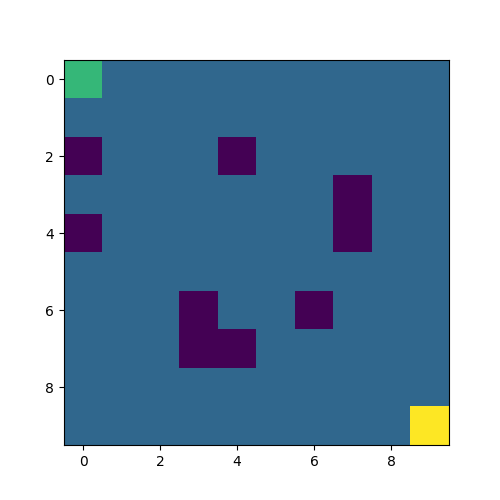

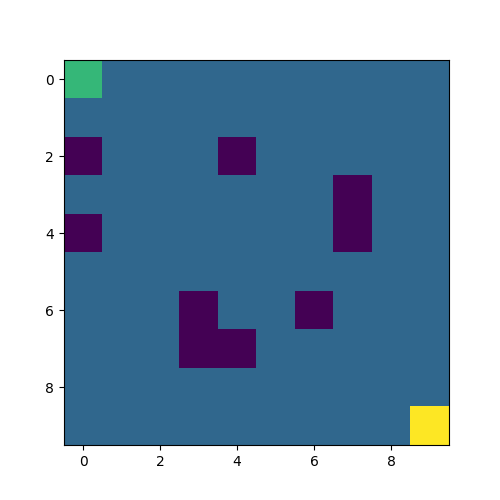

In [ ]:
_, trajectory = rollout(
    model=model,
    env=env,
    discretizer=dataset.discretizer,
    beam_width=beam_width,
    beam_steps=beam_steps,
    beam_context=beam_context,
    sample_expansion=sample_expansion,
    observation_dim=observation_dim,
    action_dim=action_dim,
    reward_dim=reward_dim,
    value_dim=value_dim,
    transition_dim=transition_dim,
    max_steps=100,
    plan_every=plan_every,
    obs_top_k=obs_top_k,
    act_top_k=act_top_k,
    rew_top_k=rew_top_k,
    temperature=1.0,
    greedy=False,
    device=device
)

shorted_trajectory = collect_trajectories(env, num_episodes=1, policy='shortest_path')[0]

an1 = animate_trajectory(env, trajectory)
an2 = animate_trajectory(env, shorted_trajectory)

print(f"Model trajectory length: {len(trajectory)}")
print(f"Shortest path trajectory length: {len(shorted_trajectory)}")